In [5]:
import networkx as nx
from collections import defaultdict

# >>> ajuste aqui <<<
gexf_path = "../data/networks/covoting-network-20251217-150245.gexf"

# carregar rede
G = nx.read_gexf(gexf_path)

print(f"N nós: {G.number_of_nodes()}")
print(f"N arestas: {G.number_of_edges()}")

# tentar detectar nome do atributo do partido
party_attr_name = None
for _, data in G.nodes(data=True):
    for candidate in ["party", "siglaPartido", "partido"]:
        if candidate in data:
            party_attr_name = candidate
            break
    if party_attr_name:
        break

print(f"Atributo de partido detectado: {party_attr_name}")

# mapear nós -> partido (ou None)
party_of = {}
for n, data in G.nodes(data=True):
    partido = data.get(party_attr_name)
    party_of[n] = partido

# acumular peso por partido
peso_por_partido = defaultdict(float)

for u, v, data in G.edges(data=True):
    w = data.get("weight", 1)

    pu = party_of.get(u)
    pv = party_of.get(v)

    # conte para ambos os lados, ignorando nós sem partido
    if pu:
        peso_por_partido[pu] += w
    if pv:
        peso_por_partido[pv] += w

# ordenar do maior para o menor
resultado = sorted(peso_por_partido.items(), key=lambda x: x[1], reverse=True)

print("\n=== PESO TOTAL POR PARTIDO ===")
for partido, peso in resultado:
    print(f"{partido:>6}  {peso:,.0f}")

N nós: 613
N arestas: 169824
Atributo de partido detectado: party

=== PESO TOTAL POR PARTIDO ===
    PL  1,527,134
    PP  1,071,864
    PT  1,064,602
 UNIÃO  1,011,686
REPUBLICANOS  923,995
   PSD  903,410
   MDB  701,917
   PSB  451,894
  PSDB  428,752
   PDT  370,190
  NOVO  181,550
  PODE  167,462
   PSC  155,881
 PCdoB  151,975
SOLIDARIEDADE  146,749
  PSOL  144,061
CIDADANIA  125,398
  PROS  112,278
AVANTE  111,386
PATRIOTA  84,739
    PV  78,574
   PTB  70,444
  REDE  40,017


In [6]:
import os
import requests
import pandas as pd

YEARS = [2019, 2020, 2021, 2022]

BASE_URL = "https://dadosabertos.camara.leg.br/arquivos/votacoes/csv/votacoes-{year}.csv"
RAW_DIR = "./data/votes/raw"

TARGET_TYPES = {"PL", "PEC", "PLN", "PLV", "PLC"}

def download_if_missing(year: int) -> str:
    os.makedirs(RAW_DIR, exist_ok=True)
    path = os.path.join(RAW_DIR, f"votacoes-{year}.csv")
    if os.path.exists(path):
        return path

    url = BASE_URL.format(year=year)
    print(f"Baixando {url}")
    r = requests.get(url, timeout=60)
    r.raise_for_status()
    with open(path, "wb") as f:
        f.write(r.content)
    return path

def detect_type_column(df: pd.DataFrame) -> str | None:
    # coluna mais comum nos CSVs da Câmara
    candidates = [
        "ultimaApresentacaoProposicao_siglaTipo",
        "ultimaApresentacaoProposicaoSiglaTipo",
        "siglaTipo",
        "proposicao_siglaTipo",
        "proposicaoSiglaTipo",
    ]
    for c in candidates:
        if c in df.columns:
            return c

    # fallback: procurar por algo que contenha "siglaTipo"
    for c in df.columns:
        if "siglaTipo" in c:
            return c

    return None

def main():
    total_votes = 0
    total_votes_with_prop = 0
    total_votes_in_target_types = 0

    per_year = []

    for year in YEARS:
        path = download_if_missing(year)
        df = pd.read_csv(path, sep=";", low_memory=False)

        n_total = len(df)
        total_votes += n_total

        type_col = detect_type_column(df)

        if type_col is None:
            print(f"\nAno {year}: não encontrei coluna de tipo de proposição (siglaTipo).")
            print(f"Colunas disponíveis (primeiras 30): {list(df.columns)[:30]}")
            per_year.append((year, n_total, None, None))
            continue

        # normalizar strings e tratar nulos
        types = (
            df[type_col]
            .astype(str)
            .str.strip()
        )

        # linhas que possuem alguma proposição associada (não vazio e não "nan")
        has_prop = (types != "") & (types.str.lower() != "nan")
        n_with_prop = int(has_prop.sum())
        total_votes_with_prop += n_with_prop

        # filtro por tipos desejados
        in_target = has_prop & types.isin(TARGET_TYPES)
        n_target = int(in_target.sum())
        total_votes_in_target_types += n_target

        per_year.append((year, n_total, n_with_prop, n_target))

    print("\n===== CONTAGEM DE VOTAÇÕES 2019-2022 =====\n")
    print(f"Total de votações (todas as linhas): {total_votes}")

    # Se algum ano não teve coluna detectada, essas métricas ficam parcialmente indefinidas
    if any(x[2] is None for x in per_year):
        print("\nAtenção: em pelo menos um ano não foi possível detectar a coluna de tipo de proposição.")
        print("Nesse caso, o total filtrado por tipo pode estar incompleto.\n")
    else:
        print(f"Total de votações com proposição associada (tipo presente): {total_votes_with_prop}")
        print(f"Total de votações cuja proposição é um dos tipos {sorted(TARGET_TYPES)}: {total_votes_in_target_types}")

    print("\nPor ano:")
    for year, n_total, n_with_prop, n_target in per_year:
        if n_with_prop is None:
            print(f"  {year}: total={n_total} | tipo de proposição: INDEFINIDO (coluna ausente)")
        else:
            print(f"  {year}: total={n_total} | com proposição={n_with_prop} | tipos alvo={n_target}")

if __name__ == "__main__":
    main()



Ano 2019: não encontrei coluna de tipo de proposição (siglaTipo).
Colunas disponíveis (primeiras 30): ['id', 'uri', 'data', 'dataHoraRegistro', 'idOrgao', 'uriOrgao', 'siglaOrgao', 'idEvento', 'uriEvento', 'aprovacao', 'votosSim', 'votosNao', 'votosOutros', 'descricao', 'ultimaAberturaVotacao_dataHoraRegistro', 'ultimaAberturaVotacao_descricao', 'ultimaApresentacaoProposicao_dataHoraRegistro', 'ultimaApresentacaoProposicao_descricao', 'ultimaApresentacaoProposicao_idProposicao', 'ultimaApresentacaoProposicao_uriProposicao']

Ano 2020: não encontrei coluna de tipo de proposição (siglaTipo).
Colunas disponíveis (primeiras 30): ['id', 'uri', 'data', 'dataHoraRegistro', 'idOrgao', 'uriOrgao', 'siglaOrgao', 'idEvento', 'uriEvento', 'aprovacao', 'votosSim', 'votosNao', 'votosOutros', 'descricao', 'ultimaAberturaVotacao_dataHoraRegistro', 'ultimaAberturaVotacao_descricao', 'ultimaApresentacaoProposicao_dataHoraRegistro', 'ultimaApresentacaoProposicao_descricao', 'ultimaApresentacaoProposicao

In [7]:
def print_graph_summary(G: nx.Graph, weight_attr: str = "weight") -> None:

    def is_multigraph(G):
        return isinstance(G, (nx.MultiGraph, nx.MultiDiGraph))

    n = G.number_of_nodes()
    m = G.number_of_edges()

    # Densidade
    density = nx.density(G) if n > 1 else 0.0

    # Coeficiente de clusterização (médio)
    # Para grafos direcionados, average_clustering usa a versão não-direcionada (projeção) ao converter.
    try:
        clustering = nx.average_clustering(G.to_undirected() if G.is_directed() else G)
    except Exception:
        clustering = float("nan")

    # Componentes conexas: usar versão não-direcionada para DiGraph
    UG = G.to_undirected() if G.is_directed() else G
    if n == 0:
        largest_cc_pct = 0.0
        largest_cc_size = 0
    else:
        try:
            largest_cc_size = max((len(c) for c in nx.connected_components(UG)), default=0)
        except nx.NetworkXNotImplemented:
            # Caso extremo: se não der connected_components, tenta weakly para directed
            if G.is_directed():
                largest_cc_size = max((len(c) for c in nx.weakly_connected_components(G)), default=0)
            else:
                largest_cc_size = 0
        largest_cc_pct = (largest_cc_size / n * 100.0) if n > 0 else 0.0

    # Graus (considerando degree total, para DiGraph é in+out)
    degrees = dict(G.degree())
    vertices_deg_gt0 = sum(1 for d in degrees.values() if d > 0)

    if n > 0:
        min_degree = min(degrees.values())
        max_degree = max(degrees.values())
        mean_degree = sum(degrees.values()) / n
    else:
        min_degree = max_degree = mean_degree = float("nan")

    # Pesos de aresta
    weights = []
    if m > 0:
        if is_multigraph(G):
            for u, v, k, data in G.edges(keys=True, data=True):
                w = data.get(weight_attr, 1.0)
                try:
                    weights.append(float(w))
                except Exception:
                    pass
        else:
            for u, v, data in G.edges(data=True):
                w = data.get(weight_attr, 1.0)
                try:
                    weights.append(float(w))
                except Exception:
                    pass

    if len(weights) > 0:
        min_w = min(weights)
        max_w = max(weights)
        mean_w = sum(weights) / len(weights)
    else:
        min_w = max_w = mean_w = float("nan")

    # Impressão
    print(f"Densidade: {density:.6f}")
    print(f"Coeficiente de Clusterização: {clustering:.6f}")
    print(f"Tamanho da maior componente conexa (%): {largest_cc_pct:.2f}% ({largest_cc_size}/{n})")
    print(f"Vértices com grau maior que zero: {vertices_deg_gt0}/{n}")
    print(f"Menor grau: {min_degree if n>0 else 'NA'}")
    print(f"Maior grau: {max_degree if n>0 else 'NA'}")
    print(f"Grau médio: {mean_degree:.6f}" if n > 0 else "Grau médio: NA")
    print(f"Menor peso de aresta: {min_w}")
    print(f"Maior peso de aresta: {max_w}")
    print(f"Peso médio de aresta: {mean_w}")

In [8]:
print_graph_summary(G, weight_attr="weight")

Densidade: 0.905351
Coeficiente de Clusterização: 0.945596
Tamanho da maior componente conexa (%): 96.74% (593/613)
Vértices com grau maior que zero: 593/613
Menor grau: 0
Maior grau: 592
Grau médio: 554.075041
Menor peso de aresta: 1.0
Maior peso de aresta: 115.0
Peso médio de aresta: 29.518672272470322


In [9]:
from collections import defaultdict
import pandas as pd

# 1) Detectar automaticamente o atributo de partido
party_attr_name = None
for _, data in G.nodes(data=True):
    for candidate in ["party", "siglaPartido", "partido"]:
        if candidate in data:
            party_attr_name = candidate
            break
    if party_attr_name:
        break

print("Atributo de partido detectado:", party_attr_name)

# 2) Mapear nós -> partido
party_of = {}
for n, data in G.nodes(data=True):
    partido = data.get(party_attr_name)
    party_of[n] = partido

# 3) Tamanho de cada partido (número de nós/deputados na rede)
nodes_by_party = defaultdict(set)
for n, p in party_of.items():
    if p:
        nodes_by_party[p].add(n)

party_sizes = {p: len(ns) for p, ns in nodes_by_party.items()}

# 4) Coautoria partido–partido (ponderada pelo weight da aresta)
#    Vamos construir uma matriz DIRECIONADA:
#    A->B = quanto do peso de coautoria "passa" de A para B
weight_by_party_pair = defaultdict(float)

for u, v, data in G.edges(data=True):
    w = data.get("weight", 1.0)

    pu = party_of.get(u)
    pv = party_of.get(v)

    # ignorar arestas onde algum lado não tem partido
    if pu is None or pv is None:
        continue

    # contar nos dois sentidos para poder olhar "do ponto de vista de A"
    weight_by_party_pair[(pu, pv)] += w
    if pu != pv:
        weight_by_party_pair[(pv, pu)] += w

# 5) Total de coautoria de cada partido A (somando A->qualquer B)
total_by_party = defaultdict(float)
for (pa, pb), w in weight_by_party_pair.items():
    total_by_party[pa] += w

# 6) DataFrame com matriz A coautora com B (peso e fração)
rows = []
for (pa, pb), w in weight_by_party_pair.items():
    total_pa = total_by_party[pa]
    frac = w / total_pa if total_pa > 0 else 0.0
    rows.append({
        "partido_A": pa,
        "partido_B": pb,
        "peso_AB": w,
        "frac_coautoria_de_A_para_B": frac
    })

df_party_party = pd.DataFrame(rows)

# 7) Para cada partido_A, encontrar o B com maior fração de coautoria
melhor_parceria = []

for partido_A in sorted(party_sizes.keys()):
    sub = df_party_party[df_party_party["partido_A"] == partido_A]
    if sub.empty:
        continue
    sub = sub.sort_values(
        by=["frac_coautoria_de_A_para_B", "peso_AB"],
        ascending=False
    )
    top = sub.iloc[0]
    melhor_parceria.append({
        "partido_A": partido_A,
        "tam_bancada_A": party_sizes.get(partido_A, 0),
        "partido_B_top": top["partido_B"],
        "peso_AB": top["peso_AB"],
        "frac_coautoria_de_A_para_B": top["frac_coautoria_de_A_para_B"]
    })

df_top_parceria = pd.DataFrame(melhor_parceria).sort_values(
    by="frac_coautoria_de_A_para_B",
    ascending=False
)

df_top_parceria.reset_index(drop=True, inplace=True)

print("Ranking: para cada partido A, qual B é o parceiro preferencial (normalizado pela coautoria total de A):")
df_top_parceria

Atributo de partido detectado: party
Ranking: para cada partido A, qual B é o parceiro preferencial (normalizado pela coautoria total de A):


,partido_A,tam_bancada_A,partido_B_top,peso_AB,frac_coautoria_de_A_para_B
0,PCdoB,9,PT,33853.0,0.226059
1,REDE,2,PT,8997.0,0.225353
2,PSOL,9,PT,30815.0,0.217041
3,PTB,5,PL,14526.0,0.206958
4,PSB,31,PT,89391.0,0.206614
5,PDT,21,PT,73544.0,0.205341
6,PP,66,PL,200926.0,0.201534
7,PATRIOTA,5,PL,16670.0,0.197664
8,PSC,11,PL,29622.0,0.191666
9,REPUBLICANOS,54,PL,158843.0,0.182285


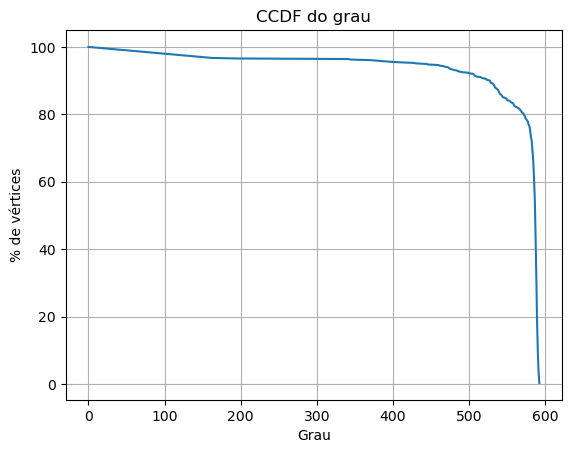

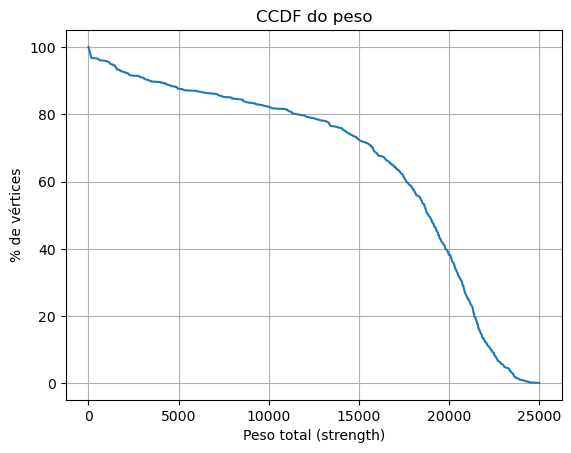

In [19]:
import numpy as np
import matplotlib.pyplot as plt
degrees = np.array([d for _, d in G.degree()])

x_deg = np.sort(np.unique(degrees))
ccdf_deg = np.array([(degrees >= xi).mean() for xi in x_deg]) * 100

plt.figure()
plt.plot(x_deg, ccdf_deg)
plt.xlabel("Grau")
plt.ylabel("% de vértices")
plt.title("CCDF do grau")
plt.grid(True)
plt.show()

# =========================
# CCDF DO PESO (STRENGTH)
# =========================
# Soma dos pesos das arestas por nó
strengths = np.array([
    sum(data.get("weight", 1.0) for _, _, data in G.edges(n, data=True))
    for n in G.nodes()
])

x_str = np.sort(np.unique(strengths))
ccdf_str = np.array([(strengths >= xi).mean() for xi in x_str]) * 100

plt.figure()
plt.plot(x_str, ccdf_str)
plt.xlabel("Peso total (strength)")
plt.ylabel("% de vértices")
plt.title("CCDF do peso")
plt.grid(True)
plt.show()

In [21]:
from __future__ import annotations

import math
from collections import Counter, defaultdict

import networkx as nx

# Opcional, mas útil para métricas de concordância
try:
    from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
    SKLEARN_OK = True
except Exception:
    SKLEARN_OK = False

def safe_str(x):
    return None if x is None else str(x)

def community_stats_by_party(G: nx.Graph, node_to_comm: dict, party_attr: str = "party"):
    # comunidade -> contagem por partido
    comm_party_counts = defaultdict(Counter)
    comm_sizes = Counter()

    for n in G.nodes():
        c = node_to_comm.get(n)
        if c is None:
            continue
        p = safe_str(G.nodes[n].get(party_attr))
        comm_party_counts[c][p] += 1
        comm_sizes[c] += 1

    # estatísticas por comunidade
    rows = []
    for c, size in comm_sizes.items():
        counts = comm_party_counts[c]
        if size == 0:
            continue

        top_party, top_count = counts.most_common(1)[0]
        purity = top_count / size

        # entropia de Shannon da distribuição de partido na comunidade
        # (0 = totalmente homogênea; maior = mais misturada)
        ent = 0.0
        for party, k in counts.items():
            if k == 0:
                continue
            p = k / size
            ent -= p * math.log(p, 2)

        rows.append({
            "community": c,
            "size": size,
            "top_party": top_party,
            "top_share": purity,
            "entropy_party": ent,
            "party_counts": dict(counts),
        })

    # ordenar por tamanho desc
    rows.sort(key=lambda r: r["size"], reverse=True)
    return rows

def main(G: nx.Graph, party_attr: str = "party", weight_attr: str = "weight",
         out_gexf_path: str = "with_louvain_covot.gexf"):

    # 1) Louvain
    # NetworkX tem louvain_communities em versões recentes.
    try:
        from networkx.algorithms.community import louvain_communities
        communities = louvain_communities(G, weight=weight_attr, seed=42)
    except Exception as e:
        raise RuntimeError(
            "Falha ao importar/rodar louvain_communities do NetworkX. "
            "Verifique a versão do networkx (ideal >= 2.8) e dependências."
        ) from e

    # Converter para mapeamento nó -> id da comunidade (int)
    node_to_comm = {}
    for cid, comm in enumerate(communities):
        for n in comm:
            node_to_comm[n] = int(cid)

    # 2) Modularidade (Q) da partição encontrada
    from networkx.algorithms.community.quality import modularity
    Q = modularity(G, communities, weight=weight_attr)

    print(f"Louvain: {len(communities)} comunidades")
    print(f"Modularidade Q (da partição Louvain): {Q:.6f}")

    # 3) Comparar Louvain vs party
    rows = community_stats_by_party(G, node_to_comm, party_attr=party_attr)

    print("\nResumo por comunidade (top 15 por tamanho):")
    for r in rows[:15]:
        print(
            f"  comm={r['community']:>3}  size={r['size']:>4}  "
            f"top_party={r['top_party']}  top_share={r['top_share']:.3f}  "
            f"entropy={r['entropy_party']:.3f}"
        )

    # Métrica global opcional: NMI e ARI entre rótulos Louvain e party (quando party existe)
    parties = []
    comm_labels = []
    for n in G.nodes():
        p = safe_str(G.nodes[n].get(party_attr))
        c = node_to_comm.get(n)
        if p is None or c is None:
            continue
        parties.append(p)
        comm_labels.append(c)

    if SKLEARN_OK and len(parties) > 0:
        nmi = normalized_mutual_info_score(parties, comm_labels)
        ari = adjusted_rand_score(parties, comm_labels)
        print(f"\nConcordância global (party vs Louvain): NMI={nmi:.4f}  ARI={ari:.4f}")
    else:
        if not SKLEARN_OK:
            print("\nsklearn não disponível: pulando NMI/ARI.")
        else:
            print("\nAtributo party ausente para todos ou quase todos os nós: pulando NMI/ARI.")

    # 4) Gravar atributos no grafo para abrir no Gephi
    nx.set_node_attributes(G, node_to_comm, "louvain")

    # Opcional: gravar também o partido normalizado como string, para evitar tipos mistos
    party_norm = {n: safe_str(G.nodes[n].get(party_attr)) for n in G.nodes()}
    nx.set_node_attributes(G, party_norm, party_attr)

    # Opcional: gravar Q em todos os nós (Gephi não lê bem metadados globais)
    nx.set_node_attributes(G, {n: float(Q) for n in G.nodes()}, "louvain_modularity_Q")

    nx.write_gexf(G, out_gexf_path)
    print(f"\nGEXF exportado: {out_gexf_path}")
    print("Atributos adicionados nos nós: 'louvain', 'louvain_modularity_Q' e o atributo de partido normalizado.")

# Exemplo de uso:
# 

In [23]:
main(G, party_attr="party", weight_attr="weight", out_gexf_path="G_louvain_covot.gexf")

Louvain: 23 comunidades
Modularidade Q (da partição Louvain): 0.145354

Resumo por comunidade (top 15 por tamanho):
  comm=  9  size= 359  top_party=PL  top_share=0.217  entropy=3.190
  comm= 13  size= 220  top_party=PT  top_share=0.268  entropy=3.589
  comm= 14  size=  14  top_party=NOVO  top_share=0.571  entropy=2.093
  comm=  0  size=   1  top_party=PSDB  top_share=1.000  entropy=0.000
  comm=  1  size=   1  top_party=UNIÃO  top_share=1.000  entropy=0.000
  comm=  2  size=   1  top_party=PL  top_share=1.000  entropy=0.000
  comm=  3  size=   1  top_party=PT  top_share=1.000  entropy=0.000
  comm=  4  size=   1  top_party=PSD  top_share=1.000  entropy=0.000
  comm=  5  size=   1  top_party=PP  top_share=1.000  entropy=0.000
  comm=  6  size=   1  top_party=PSB  top_share=1.000  entropy=0.000
  comm=  7  size=   1  top_party=SOLIDARIEDADE  top_share=1.000  entropy=0.000
  comm=  8  size=   1  top_party=PTB  top_share=1.000  entropy=0.000
  comm= 10  size=   1  top_party=PODE  top_shar

In [24]:
import math
from collections import Counter, defaultdict

import numpy as np

def _is_number(x):
    if x is None:
        return False
    if isinstance(x, (int, float, np.integer, np.floating)) and not (isinstance(x, float) and math.isnan(x)):
        return True
    # tentar converter strings numéricas
    if isinstance(x, str):
        try:
            float(x.replace(",", "."))
            return True
        except Exception:
            return False
    return False

def _to_float(x):
    if x is None:
        return None
    if isinstance(x, (int, float, np.integer, np.floating)):
        if isinstance(x, float) and math.isnan(x):
            return None
        return float(x)
    if isinstance(x, str):
        try:
            return float(x.replace(",", "."))
        except Exception:
            return None
    return None

def _cramers_v_from_contingency(table_2d):
    """
    table_2d: array shape (r, c), aqui c=2 (in/out).
    Retorna Cramér's V.
    """
    X = np.array(table_2d, dtype=float)
    n = X.sum()
    if n <= 0:
        return 0.0

    row_sums = X.sum(axis=1, keepdims=True)
    col_sums = X.sum(axis=0, keepdims=True)
    expected = (row_sums @ col_sums) / n

    # evitar divisão por zero
    with np.errstate(divide="ignore", invalid="ignore"):
        chi2 = np.nansum((X - expected) ** 2 / expected)

    r, c = X.shape
    if r <= 1 or c <= 1:
        return 0.0

    denom = n * (min(r - 1, c - 1))
    if denom <= 0:
        return 0.0
    return float(math.sqrt(chi2 / denom))

def _point_biserial_corr(values, membership01):
    """
    values: lista de floats
    membership01: lista de 0/1 (mesmo tamanho)
    Retorna correlação ponto bisserial (equivalente ao Pearson entre x e indicador binário).
    """
    x = np.array(values, dtype=float)
    y = np.array(membership01, dtype=float)
    if len(x) < 3:
        return 0.0
    if np.all(y == y[0]):
        return 0.0
    if np.std(x) == 0:
        return 0.0
    r = np.corrcoef(x, y)[0, 1]
    if np.isnan(r):
        return 0.0
    return float(abs(r))  # magnitude da associação

def analyze_partition_best_attribute(G, comm_key, exclude_keys=None, min_valid_frac=0.6, top_k_print=10):
    """
    Para cada comunidade, escolhe o atributo de nó com maior associação
    (Cramér's V para categórico; ponto bisserial para numérico)
    entre "estar na comunidade" vs "não estar".
    """
    if exclude_keys is None:
        exclude_keys = set()
    else:
        exclude_keys = set(exclude_keys)

    exclude_keys |= {comm_key, "louvain_modularity_Q", "louvain","newman_modularity_Q"}

    # comunidades existentes
    comm_of = {}
    for n, data in G.nodes(data=True):
        if comm_key in data:
            comm_of[n] = data[comm_key]

    comm_ids = sorted(set(comm_of.values()))
    n_total = len(comm_of)
    if n_total == 0:
        raise ValueError(f"Nenhum nó tem o atributo {comm_key}.")

    # coletar chaves de atributos candidatas
    all_keys = set()
    for n, data in G.nodes(data=True):
        if n not in comm_of:
            continue
        for k in data.keys():
            if k in exclude_keys:
                continue
            all_keys.add(k)

    # pré coletar valores por atributo para acelerar
    attr_values = {k: {} for k in all_keys}  # attr -> {node: value}
    for n, data in G.nodes(data=True):
        if n not in comm_of:
            continue
        for k in all_keys:
            if k in data:
                attr_values[k][n] = data.get(k)

    # análise por comunidade
    results = []
    for cid in comm_ids:
        nodes_in = [n for n in comm_of if comm_of[n] == cid]
        nodes_out = [n for n in comm_of if comm_of[n] != cid]
        size_in = len(nodes_in)
        if size_in == 0:
            continue

        best = None  # (score, attr_name, kind, top_value, top_pct, extra)
        for attr in all_keys:
            vals_map = attr_values[attr]
            # valores válidos entre in e out
            in_vals = []
            out_vals = []
            for n in nodes_in:
                if n in vals_map and vals_map[n] is not None:
                    in_vals.append(vals_map[n])
            for n in nodes_out:
                if n in vals_map and vals_map[n] is not None:
                    out_vals.append(vals_map[n])

            valid = len(in_vals) + len(out_vals)
            if valid == 0:
                continue
            if valid / (len(nodes_in) + len(nodes_out)) < min_valid_frac:
                continue

            # decidir tipo numérico vs categórico
            in_num = sum(_is_number(v) for v in in_vals)
            out_num = sum(_is_number(v) for v in out_vals)
            num_frac = (in_num + out_num) / max(1, valid)

            if num_frac >= 0.9:
                # numérico
                X = []
                Y = []
                for n in nodes_in:
                    if n in vals_map:
                        f = _to_float(vals_map[n])
                        if f is not None:
                            X.append(f)
                            Y.append(1)
                for n in nodes_out:
                    if n in vals_map:
                        f = _to_float(vals_map[n])
                        if f is not None:
                            X.append(f)
                            Y.append(0)

                score = _point_biserial_corr(X, Y)
                kind = "numeric"

                # para reportar, usar média dentro e fora
                x_in = [ _to_float(vals_map[n]) for n in nodes_in if _to_float(vals_map.get(n)) is not None ]
                x_out = [ _to_float(vals_map[n]) for n in nodes_out if _to_float(vals_map.get(n)) is not None ]
                mu_in = float(np.mean(x_in)) if len(x_in) else None
                mu_out = float(np.mean(x_out)) if len(x_out) else None
                top_value = f"mean_in={mu_in:.3g}, mean_out={mu_out:.3g}" if (mu_in is not None and mu_out is not None) else "mean_in/out unavailable"
                top_pct = None

            else:
                # categórico
                # construir contingência: categorias x {in,out}
                counter_in = Counter(str(v) for v in in_vals)
                counter_out = Counter(str(v) for v in out_vals)

                cats = sorted(set(counter_in.keys()) | set(counter_out.keys()))
                if len(cats) <= 1:
                    continue

                table = []
                for c in cats:
                    table.append([counter_in.get(c, 0), counter_out.get(c, 0)])

                score = _cramers_v_from_contingency(table)
                kind = "categorical"

                # reportar categoria mais comum dentro da comunidade e seu percentual interno
                top_cat, top_count = counter_in.most_common(1)[0]
                top_value = top_cat
                top_pct = (top_count / sum(counter_in.values())) * 100.0 if sum(counter_in.values()) > 0 else 0.0

            if best is None or score > best[0]:
                best = (score, attr, kind, top_value, top_pct)

        results.append((cid, size_in, best))

    # ordenar por tamanho desc
    results.sort(key=lambda x: x[1], reverse=True)

    # imprimir
    print(f"{comm_key.capitalize()}, {len(results)} comunidades.")
    print("")
    for cid, size_in, best in results[:top_k_print]:
        if best is None:
            print(f"Comunidade {cid}: sem atributo elegível (dados insuficientes).")
            continue
        score, attr, kind, top_value, top_pct = best
        if kind == "categorical":
            print(f"Comunidade {cid}: Atributo com maior associação: {attr}. {top_value} ({top_pct:.1f}%). V={score:.3f}")
        else:
            print(f"Comunidade {cid}: Atributo com maior associação: {attr}. {top_value}. |r|={score:.3f}")

    return results


# Executar para Louvain
# Ajuste exclude_keys se você tiver colunas que não são atributos substantivos (ex.: "label", "id", "name")
louvain_results = analyze_partition_best_attribute(
    G,
    comm_key="louvain",
    exclude_keys={"id", "name", "label"},
    min_valid_frac=0.6,
    top_k_print=50  # coloque 50 se quiser listar todas
)

Louvain, 23 comunidades.

Comunidade 9: Atributo com maior associação: party. PL (21.7%). V=0.746
Comunidade 13: Atributo com maior associação: party. PT (26.8%). V=0.727
Comunidade 14: Atributo com maior associação: party. NOVO (57.1%). V=0.767
Comunidade 0: Atributo com maior associação: uf. MS (100.0%). V=0.314
Comunidade 1: Atributo com maior associação: uf. RJ (100.0%). V=0.125
Comunidade 2: Atributo com maior associação: uf. CE (100.0%). V=0.172
Comunidade 3: Atributo com maior associação: education. Doutorado (100.0%). V=0.205
Comunidade 4: Atributo com maior associação: party. PSD (100.0%). V=0.125
Comunidade 5: Atributo com maior associação: uf. PI (100.0%). V=0.275
Comunidade 6: Atributo com maior associação: uf. PE (100.0%). V=0.181
Comunidade 7: Atributo com maior associação: party. SOLIDARIEDADE (100.0%). V=0.331
Comunidade 8: Atributo com maior associação: party. PTB (100.0%). V=0.446
Comunidade 10: Atributo com maior associação: uf. RN (100.0%). V=0.314
Comunidade 11: At

In [25]:
from __future__ import annotations

import math
from collections import Counter, defaultdict
from typing import Dict, Iterable, List, Sequence, Set, Tuple

import numpy as np
import networkx as nx


def _safe_str(x):
    return None if x is None else str(x)


def _global_weighted_degrees(G: nx.Graph, weight: str) -> Dict:
    # grau ponderado global (no grafo inteiro), como no modelo nulo da modularidade
    return dict(G.degree(weight=weight))


def _global_total_weight(G: nx.Graph, weight: str) -> float:
    # para grafo não direcionado, m = soma dos pesos das arestas
    return float(G.size(weight=weight))


def _build_B_subgraph(
    nodes: Sequence,
    A: np.ndarray,
    k_global: Dict,
    m: float,
) -> np.ndarray:
    """
    Constrói a matriz B^g (Newman) para um conjunto de nós 'nodes' (subproblema).
    A é a adjacência ponderada induzida por 'nodes' (matriz densa).
    k_global é o grau ponderado global de cada nó no grafo original.
    m é o peso total do grafo (soma de pesos das arestas).
    """
    n = len(nodes)
    k = np.array([k_global[v] for v in nodes], dtype=float)

    # B = A - (k_i k_j) / (2m)
    B = A - np.outer(k, k) / (2.0 * m)

    # Ajuste do subgrafo: B^g = B - diag(sum_j B_ij)
    row_sums = B.sum(axis=1)
    Bg = B - np.diag(row_sums)

    return Bg


def _leading_eigenvector(B: np.ndarray) -> Tuple[float, np.ndarray]:
    """
    Retorna (lambda_max, v_max) para uma matriz simétrica B.
    Usa eigh (autovalores reais). Para tamanhos moderados é suficiente.
    """
    vals, vecs = np.linalg.eigh(B)
    idx = int(np.argmax(vals))
    return float(vals[idx]), vecs[:, idx]


def _delta_Q(Bg: np.ndarray, s: np.ndarray, m: float) -> float:
    """
    ΔQ = (1/(4m)) s^T Bg s
    """
    return float((s.T @ Bg @ s) / (4.0 * m))


def newman_leading_eigenvector_communities(
    G: nx.Graph,
    weight: str = "weight",
    min_comm_size: int = 1,
) -> List[Set]:
    """
    Implementação recursiva do método espectral de Newman para maximizar modularidade.
    Divide um conjunto de nós em dois se houver ganho positivo de modularidade.

    min_comm_size: impede divisões que gerariam comunidades menores que este tamanho.
    """
    if nx.is_directed(G):
        raise ValueError("Este script espera um grafo não direcionado (nx.Graph).")

    m = _global_total_weight(G, weight=weight)
    if m <= 0:
        # sem arestas (ou pesos zero): cada nó vira uma comunidade
        return [{n} for n in G.nodes()]

    k_global = _global_weighted_degrees(G, weight=weight)

    # fila de conjuntos a avaliar
    pending: List[Set] = [set(G.nodes())]
    final_comms: List[Set] = []

    while pending:
        S = pending.pop()

        # se for pequeno demais para dividir, finalize
        if len(S) < 2 * max(1, min_comm_size):
            final_comms.append(S)
            continue

        nodes = list(S)

        # matriz de adjacência ponderada do subgrafo induzido por S
        A = nx.to_numpy_array(G, nodelist=nodes, weight=weight, dtype=float)

        Bg = _build_B_subgraph(nodes=nodes, A=A, k_global=k_global, m=m)

        lam, v = _leading_eigenvector(Bg)

        # se o maior autovalor não for positivo, não há divisão que aumente Q via este critério
        if lam <= 1e-12:
            final_comms.append(S)
            continue

        # vetor de partição s pela regra do sinal
        s = np.ones(len(nodes), dtype=float)
        s[v < 0] = -1.0

        # evitar partição degenerada (todos do mesmo lado)
        if np.all(s > 0) or np.all(s < 0):
            final_comms.append(S)
            continue

        # construir os dois grupos
        S_pos = {nodes[i] for i in range(len(nodes)) if s[i] > 0}
        S_neg = set(nodes) - S_pos

        # respeitar tamanho mínimo
        if len(S_pos) < min_comm_size or len(S_neg) < min_comm_size:
            final_comms.append(S)
            continue

        dQ = _delta_Q(Bg, s, m)

        # só divide se houver ganho positivo de modularidade
        if dQ > 1e-12:
            pending.append(S_pos)
            pending.append(S_neg)
        else:
            final_comms.append(S)

    return final_comms


def summarize_by_party(
    G: nx.Graph,
    node_to_comm: Dict,
    party_attr: str = "party",
    top_k: int = 15,
):
    comm_counts = defaultdict(Counter)
    comm_sizes = Counter()

    for n in G.nodes():
        c = node_to_comm.get(n)
        p = _safe_str(G.nodes[n].get(party_attr))
        comm_counts[c][p] += 1
        comm_sizes[c] += 1

    rows = []
    for c, size in comm_sizes.items():
        top_party, top_count = comm_counts[c].most_common(1)[0]
        top_share = top_count / size

        ent = 0.0
        for _, k in comm_counts[c].items():
            if k <= 0:
                continue
            pr = k / size
            ent -= pr * math.log(pr, 2)

        rows.append((c, size, top_party, top_share, ent))

    rows.sort(key=lambda x: x[1], reverse=True)

    print(f"\nResumo (top {top_k}) comunidade vs party:")
    for c, size, top_party, top_share, ent in rows[:top_k]:
        print(
            f"  comm={int(c):>3}  size={size:>4}  top_party={top_party}  "
            f"top_share={top_share:.3f}  entropy={ent:.3f}"
        )


def run_newman_and_export(
    G: nx.Graph,
    weight_attr: str = "weight",
    party_attr: str = "party",
    out_gexf_path: str = "G_newman_covot.gexf",
    min_comm_size: int = 1,
):
    # garantir que todas as arestas têm peso
    for _, _, data in G.edges(data=True):
        data.setdefault(weight_attr, 1.0)

    communities = newman_leading_eigenvector_communities(
        G, weight=weight_attr, min_comm_size=min_comm_size
    )

    from networkx.algorithms.community.quality import modularity
    Q = modularity(G, communities, weight=weight_attr)

    print(f"Newman (spectral): {len(communities)} comunidades")
    print(f"Modularidade Q (partição Newman): {Q:.6f}")

    # mapear nó -> id de comunidade
    node_to_comm = {}
    for cid, comm in enumerate(communities):
        for n in comm:
            node_to_comm[n] = int(cid)

    # anexar atributos para Gephi
    nx.set_node_attributes(G, node_to_comm, "newman")
    nx.set_node_attributes(G, {n: float(Q) for n in G.nodes()}, "newman_modularity_Q")

    # normalizar party como string para evitar tipos mistos no Gephi
    party_norm = {n: _safe_str(G.nodes[n].get(party_attr)) for n in G.nodes()}
    nx.set_node_attributes(G, party_norm, party_attr)

    nx.write_gexf(G, out_gexf_path)
    print(f"GEXF exportado: {out_gexf_path}")
    print("Colunas de nó adicionadas: 'newman' e 'newman_modularity_Q'.")

    # opcional: resumo por party
    summarize_by_party(G, node_to_comm, party_attr=party_attr)


# Uso:
# 

In [26]:
run_newman_and_export(G, weight_attr="weight", party_attr="party", out_gexf_path="G_newman_covot.gexf", min_comm_size=1)

Newman (spectral): 2 comunidades
Modularidade Q (partição Newman): 0.145222
GEXF exportado: G_newman_covot.gexf
Colunas de nó adicionadas: 'newman' e 'newman_modularity_Q'.

Resumo (top 15) comunidade vs party:
  comm=  1  size= 393  top_party=PL  top_share=0.201  entropy=3.428
  comm=  0  size= 220  top_party=PT  top_share=0.268  entropy=3.590


In [28]:
# Executar para Newman
newman_results = analyze_partition_best_attribute(
    G,
    comm_key="newman",
    exclude_keys={"id", "name", "label"},
    min_valid_frac=0.6,
    top_k_print=50  # coloque 50 se quiser listar todas
)

Newman, 2 comunidades.

Comunidade 1: Atributo com maior associação: party. PL (20.1%). V=0.727
Comunidade 0: Atributo com maior associação: party. PT (26.8%). V=0.727


In [31]:
import networkx as nx
from collections import defaultdict

def _get_party_attr_name(G):
    for _, data in G.nodes(data=True):
        for cand in ["party", "siglaPartido", "partido"]:
            if cand in data:
                return cand
    return None

def modularity_by_party(G, exclude_nodes=None):
    """
    Calcula a modularidade da partição definida pelo atributo de partido.
    exclude_nodes: conjunto opcional de nós a excluir antes do cálculo.
    """
    H = G
    if exclude_nodes is not None and len(exclude_nodes) > 0:
        H = G.copy()
        H.remove_nodes_from([n for n in exclude_nodes if n in H])

    party_attr = _get_party_attr_name(H)
    if party_attr is None:
        raise ValueError("Não encontrei atributo de partido no grafo (party/siglaPartido/partido).")

    # construir partição: lista de conjuntos de nós
    buckets = defaultdict(set)
    missing = 0
    for n, data in H.nodes(data=True):
        p = data.get(party_attr, None)
        if p is None or str(p).strip() == "" or str(p).lower() == "nan":
            p = "__MISSING__"
            missing += 1
        buckets[str(p)].add(n)

    communities = list(buckets.values())

    Q = nx.algorithms.community.quality.modularity(H, communities, weight="weight")
    return Q, party_attr, len(communities), missing, H.number_of_nodes(), H.number_of_edges()


# =========================
# 1) Modularidade por partido na rede inteira
# =========================
Q_all, party_attr, k_parts_all, n_missing_all, n_nodes_all, n_edges_all = modularity_by_party(G)

print("\n===== MODULARIDADE POR PARTIDO (REDE INTEIRA) =====")
print(f"Atributo usado: {party_attr}")
print(f"Nós: {n_nodes_all} | Arestas: {n_edges_all}")
print(f"N grupos (partidos + missing): {k_parts_all} | nós sem partido: {n_missing_all}")
print(f"Modularidade Q: {Q_all:.6f}")


# =========================
# 2) Excluir grau 0 e restringir à maior componente conexa, modularidade por partido
# =========================
deg0 = {n for n in G.nodes() if G.degree(n) == 0}
H = G.copy()
H.remove_nodes_from(list(deg0))

if H.number_of_nodes() == 0:
    raise ValueError("Após remover nós de grau 0, o grafo ficou vazio.")

# maior componente conexa (para grafo não direcionado)
gcc_nodes = max(nx.connected_components(H), key=len)
H_gcc = H.subgraph(gcc_nodes).copy()

Q_gcc, party_attr2, k_parts_gcc, n_missing_gcc, n_nodes_gcc, n_edges_gcc = modularity_by_party(H_gcc)

print("\n===== MODULARIDADE POR PARTIDO (SEM GRAU 0 + MAIOR COMPONENTE) =====")
print(f"Atributo usado: {party_attr2}")
print(f"Nós: {n_nodes_gcc} | Arestas: {n_edges_gcc}")
print(f"N grupos (partidos + missing): {k_parts_gcc} | nós sem partido: {n_missing_gcc}")
print(f"Modularidade Q: {Q_gcc:.6f}")


===== MODULARIDADE POR PARTIDO (REDE INTEIRA) =====
Atributo usado: party
Nós: 613 | Arestas: 169824
N grupos (partidos + missing): 23 | nós sem partido: 0
Modularidade Q: 0.032261

===== MODULARIDADE POR PARTIDO (SEM GRAU 0 + MAIOR COMPONENTE) =====
Atributo usado: party
Nós: 593 | Arestas: 169824
N grupos (partidos + missing): 23 | nós sem partido: 0
Modularidade Q: 0.032261
